<a href="https://colab.research.google.com/github/adamceek/gpx-hr-analyzer/blob/main/comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🧹 Clean up mount point (if something was broken before)
from google.colab import drive, files
import shutil
import os

if os.path.ismount('/content/drive'):
    drive.flush_and_unmount()

if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive')

# 🔁 Re-mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# 🗑️ Remove previous .gpx files from the directory
import glob
import os
from google.colab import files

for f in glob.glob("*.gpx"):
    try:
        os.remove(f)
    except FileNotFoundError:
        pass

# ⬆️ Upload new GPX files
uploaded = files.upload()

# 📝 List uploaded filenames
uploaded_files = list(uploaded.keys())
print("Uploaded files:", uploaded_files)

# ❗ Assign them based on content in the filename (e.g., 'garmin', 'huawei')
file1 = next(f for f in uploaded_files if 'garmin' in f.lower())
file2 = next(f for f in uploaded_files if 'huawei' in f.lower())


Saving huawei_right.gpx to huawei_right.gpx
Saving garmin.gpx to garmin.gpx
Nahrané súbory: ['huawei_right.gpx', 'garmin.gpx']



⌚ Offset results:
  Offset  -6 sec → Accuracy: 97.87%, Corr: 0.9801
  Offset  -5 sec → Accuracy: 98.23%, Corr: 0.9829
  Offset  -4 sec → Accuracy: 98.23%, Corr: 0.9845
  Offset  -3 sec → Accuracy: 98.05%, Corr: 0.9844
  Offset  -2 sec → Accuracy: 97.61%, Corr: 0.9828
  Offset  -1 sec → Accuracy: 97.17%, Corr: 0.9799
  Offset  +0 sec → Accuracy: 96.46%, Corr: 0.9756
  Offset  +1 sec → Accuracy: 95.75%, Corr: 0.9700
  Offset  +2 sec → Accuracy: 94.87%, Corr: 0.9635
🖼️ Chart saved as image: /content/drive/MyDrive/HR_IMG/27_07_2025_chart.png


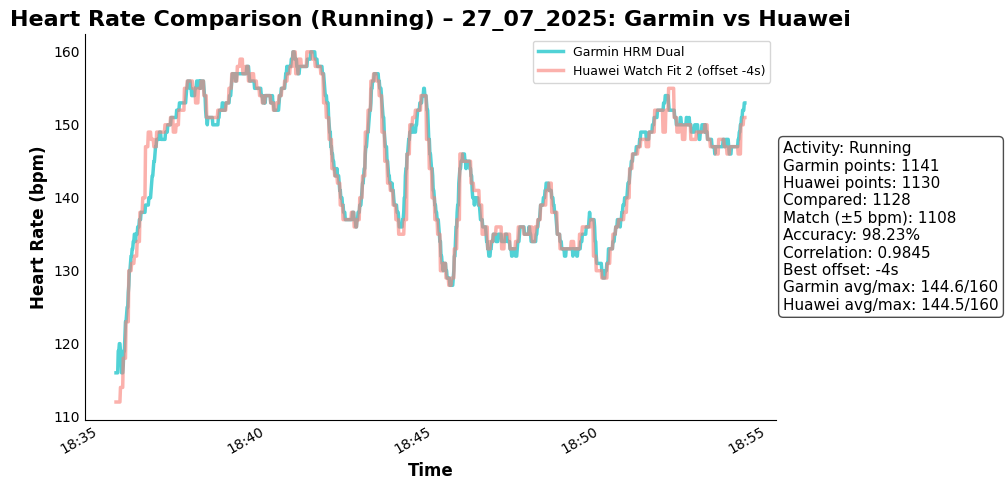

✅ Result appended to: /content/drive/MyDrive/HR_IMG/comparison.tsv
✅ File exists (Path.exists()?):  True
📂 Directory content: ['15_07_2025_graf.png', '13_07_2025_graf.png', '11_07_2025_graf.png', '19_07_2025_graf.png', 'porovnania.tsv', '20_07_2025_chart.png', '22_07_2025_chart.png', 'comparison.tsv', '27_07_2025_chart.png']


In [3]:
# script: comparison.py

import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import os
from pathlib import Path

# === 🗂️ FOLDER PATHS (at the beginning of the file) ===
DRIVE_BASE = "/content/drive/MyDrive"
IMG_DIR = os.path.join(DRIVE_BASE, "HR_IMG")
TSV_DIR = os.path.join(DRIVE_BASE, "Programming/Strava/Garmin vs Huawei/Files/TSV")
TSV_PATH = os.path.join(IMG_DIR, "comparison.tsv")

# === ⚙️ SETTINGS ===
TOLERANCE = 5
OFFSET_RANGE = range(-6, 3)
START_TIME_STR = None
END_TIME_STR = None

file1 = 'mobile.gpx'
file2 = 'huawei_right.gpx'
hand_label = "Right" if 'right' in file2.lower() else 'Left'
label1 = "Garmin HRM Dual"
label2 = "Huawei Watch Fit 2"
tolerance_str = f"±{TOLERANCE} bpm"

START_TIME = datetime.strptime(START_TIME_STR, "%H:%M").time() if START_TIME_STR else None
END_TIME = datetime.strptime(END_TIME_STR, "%H:%M").time() if END_TIME_STR else None

# === 🗓️ ACTIVITY DATE AND TYPE ===
def get_activity_date(filepath):
    ns = {'default': 'http://www.topografix.com/GPX/1/1'}
    tree = ET.parse(filepath)
    root = tree.getroot()
    for trkpt in root.findall('.//default:trkpt', ns):
        time_elem = trkpt.find('default:time', ns)
        if time_elem is not None:
            dt = datetime.fromisoformat(time_elem.text.replace("Z", "+00:00"))
            return dt.strftime("%d_%m_%Y")
    return "unknown_date"

def get_activity_type(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    for elem in root.iter():
        if elem.tag.lower().endswith("type") and elem.text:
            return elem.text.strip().capitalize()
    return "Unknown"

comparison_label = get_activity_date(file1)
activity_type = get_activity_type(file1)

# === ❤️ HR DATA EXTRACTION ===
def extract_hr_data(filepath, time_offset_sec=0):
    ns = {
        'default': 'http://www.topografix.com/GPX/1/1',
        'gpxtpx': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'
    }
    tree = ET.parse(filepath)
    root = tree.getroot()
    data = {}
    for trkpt in root.findall('.//default:trkpt', ns):
        time_elem = trkpt.find('default:time', ns)
        hr_elem = trkpt.find('.//gpxtpx:hr', ns)
        if time_elem is not None and hr_elem is not None:
            t = datetime.fromisoformat(time_elem.text.replace("Z", "+00:00")) + timedelta(hours=2, seconds=time_offset_sec)
            t = t.replace(microsecond=0)
            if ((START_TIME is None or t.time() >= START_TIME) and
                (END_TIME is None or t.time() <= END_TIME)):
                data[t] = int(hr_elem.text)
    return data

# === 🕳️ GAP DETECTION ===
def find_gaps(reference_times, compare_times, max_gap=10):
    gaps = []
    ref_set = set(reference_times)
    cmp_set = set(compare_times)
    all_times = sorted(set(reference_times + compare_times))
    for i in range(1, len(all_times)):
        delta = (all_times[i] - all_times[i - 1]).total_seconds()
        if delta > max_gap:
            ts1 = all_times[i - 1]
            ts2 = all_times[i]
            in_ref = ts1 in ref_set or ts2 in ref_set
            in_cmp = ts1 in cmp_set or ts2 in cmp_set
            if in_ref and not in_cmp:
                gaps.append((ts1, ts2, 'huawei'))
            elif in_cmp and not in_ref:
                gaps.append((ts1, ts2, 'garmin'))
            elif not in_ref and not in_cmp:
                gaps.append((ts1, ts2, 'both'))
    return gaps

# === 🧮 LOAD & ANALYZE DATA ===
data1 = extract_hr_data(file1)
total_points1 = len(data1)

results = []
for offset in OFFSET_RANGE:
    data2 = extract_hr_data(file2, time_offset_sec=offset)
    total_points2 = len(data2)
    common_times = sorted(set(data1.keys()) & set(data2.keys()))
    if not common_times:
        continue
    hr1 = [data1[t] for t in common_times]
    hr2 = [data2[t] for t in common_times]
    match_count = sum(1 for g, h in zip(hr1, hr2) if abs(g - h) <= TOLERANCE)
    accuracy = (match_count / len(common_times)) * 100
    corr = np.corrcoef(hr1, hr2)[0, 1] if len(common_times) >= 2 else None
    results.append({
        'offset': offset,
        'accuracy': accuracy,
        'corr': corr,
        'common_times': common_times,
        'hr1': hr1,
        'hr2': hr2,
        'total_points2': total_points2,
        'match_count': match_count,
        'data2': data2
    })

best_result = max(results, key=lambda x: x['accuracy'])
offset_str = f"{best_result['offset']}s"
accuracy_str = f"{best_result['accuracy']:.2f}%"
corr_str = f"{best_result['corr']:.4f}"
match_count = best_result['match_count']

print("\n⌚ Offset results:")
for r in results:
    print(f"  Offset {r['offset']:>+3} sec → Accuracy: {r['accuracy']:.2f}%, Corr: {r['corr']:.4f}")

# === 📈 VISUALIZATION ===
fig, ax = plt.subplots(figsize=(10, 5))
gaps = find_gaps(sorted(data1.keys()), list(best_result['data2'].keys()))
colors = {'huawei': 'gray', 'garmin': 'orange', 'both': 'black'}
labels_drawn = set()
for start, end, label in gaps:
    if label not in labels_drawn:
        ax.axvspan(start, end, color=colors[label], alpha=0.2, zorder=0, label=label)
        labels_drawn.add(label)
    else:
        ax.axvspan(start, end, color=colors[label], alpha=0.2, zorder=0)

ax.plot(best_result['common_times'], best_result['hr1'], label=label1, color='#51D2D6', linewidth=2.5, zorder=1)
ax.plot(best_result['common_times'], best_result['hr2'], label=f"{label2} (offset {best_result['offset']}s)", color='#F97D75', linewidth=2.5, alpha=0.6, zorder=2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()

avg1 = np.mean(best_result['hr1'])
avg2 = np.mean(best_result['hr2'])
max1 = np.max(best_result['hr1'])
max2 = np.max(best_result['hr2'])

info_text = (
    f"Activity: {activity_type}\n"
    f"Garmin points: {total_points1}\n"
    f"Huawei points: {best_result['total_points2']}\n"
    f"Compared: {len(best_result['common_times'])}\n"
    f"Match (±{TOLERANCE} bpm): {match_count}\n"
    f"Accuracy: {accuracy_str}\n"
    f"Correlation: {corr_str}\n"
    f"Best offset: {offset_str}\n"
    f"Garmin avg/max: {avg1:.1f}/{max1}\n"
    f"Huawei avg/max: {avg2:.1f}/{max2}"
)

ax.set_title(f"Heart Rate Comparison ({activity_type}) – {comparison_label}: Garmin vs Huawei", fontsize=16, weight='bold')
ax.set_xlabel("Time", fontsize=12, weight='bold')
ax.set_ylabel("Heart Rate (bpm)", fontsize=12, weight='bold')
ax.legend(loc="upper right", fontsize=9)

ax.text(1.01, 0.5, info_text, transform=ax.transAxes, fontsize=11, verticalalignment='center', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))

ax.grid(False)
ax.tick_params(axis='both', which='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# === 💾 SAVE CHART ===
os.makedirs(IMG_DIR, exist_ok=True)
img_filename = f"{comparison_label}_chart.png"
img_filepath = os.path.join(IMG_DIR, img_filename)
plt.savefig(img_filepath, bbox_inches='tight', dpi=300)
print(f"🖼️ Chart saved as image: {img_filepath}")
plt.show()

# === 📄 SAVE TO TSV ===
os.makedirs(TSV_DIR, exist_ok=True)
if not os.path.exists(TSV_PATH):
    with open(TSV_PATH, "w", encoding="utf-8") as f:
        f.write("Date\tActivity\tTolerance\tGarminPoints\tMatchedPoints\tAccuracy\tCorrelation\tHand\tOffset\n")

output_line = f"{comparison_label}\t{activity_type}\t{tolerance_str}\t{total_points1}\t{match_count}\t{accuracy_str}\t{corr_str}\t{hand_label}\t{offset_str}\n"

with open(TSV_PATH, "a", encoding="utf-8") as f:
    f.write(output_line)

print(f"✅ Result appended to: {TSV_PATH}")
print("✅ File exists (Path.exists()?): ", Path(img_filepath).exists())
print("📂 Directory content:", os.listdir(IMG_DIR))